In [19]:
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report
from qiskit.circuit.library import ZZFeatureMap
from qiskit_aer import AerSimulator
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel

# Load the .mat file
data = scipy.io.loadmat('data/data/BCIC_data/Extracted_Features/Features_B01_11.mat')

# Extract features and labels
X = data['input']   # Replace 'input' with the correct variable name if different
y = data['target']  # Replace 'target' with the correct variable name if different

# Check the shapes
print("Features shape:", X.shape)
print("Labels shape:", y.shape)

# Convert complex values to real if necessary
X = np.real(X)

# Normalize the feature matrix
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Ensure labels are a 1D array
y = y.flatten()

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=10)  # Adjust the number of components as needed
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)  # Transform test data with the same PCA

# Define quantum feature map
feature_map = ZZFeatureMap(feature_dimension=X_train_reduced.shape[1], entanglement='linear')

# Initialize the quantum backend
simulator = AerSimulator()

# Define the quantum kernel
quantum_kernel = FidelityQuantumKernel(feature_map=feature_map)

# Initialize QSVC
qsvc = QSVC(quantum_kernel=quantum_kernel)

# Train the QSVC
qsvc.fit(X_train_reduced, y_train)

# Predict on test data
y_pred = qsvc.predict(X_test_reduced)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Features shape: (720, 119)
Labels shape: (1, 720)
Accuracy: 0.4930555555555556
Classification Report:
               precision    recall  f1-score   support

         0.0       0.48      0.74      0.58        68
         1.0       0.54      0.28      0.37        76

    accuracy                           0.49       144
   macro avg       0.51      0.51      0.47       144
weighted avg       0.51      0.49      0.47       144



In [ ]:
import numpy as np
import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from qiskit.circuit.library import ZZFeatureMap
from qiskit_aer import AerSimulator
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel
import matplotlib.pyplot as plt

# Load the .mat file
data = scipy.io.loadmat('data/data/BCIC_data/Extracted_Features/Features_B01_11.mat')

# Extract features and labels
X = data['input']   # Replace 'input' with the correct variable name if different
y = data['target']  # Replace 'target' with the correct variable name if different

# Convert complex values to real if necessary
X = np.real(X)

# Normalize the feature matrix
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Ensure labels are a 1D array
y = y.flatten()

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Experiment with different numbers of PCA components
num_components_list = [5, 10, 20, 50, 100]  # Different numbers of components to try
accuracies = []
explained_variance_ratios = []

for n_components in num_components_list:
    # Apply PCA
    pca = PCA(n_components=n_components)
    X_train_reduced = pca.fit_transform(X_train)
    X_test_reduced = pca.transform(X_test)

    # Store the explained variance ratio
    explained_variance_ratios.append(pca.explained_variance_ratio_.sum())

    # Define quantum feature map and kernel
    feature_map = ZZFeatureMap(feature_dimension=X_train_reduced.shape[1], entanglement='linear')
    quantum_kernel = FidelityQuantumKernel(feature_map=feature_map)

    # Initialize and train QSVC
    qsvc = QSVC(quantum_kernel=quantum_kernel)
    qsvc.fit(X_train_reduced, y_train)

    # Predict and evaluate
    y_pred = qsvc.predict(X_test_reduced)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f"Number of Components: {n_components}, Accuracy: {accuracy}")

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(num_components_list, explained_variance_ratios, marker='o')
plt.title('Explained Variance Ratio by Number of PCA Components')
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

# Plot accuracies
plt.figure(figsize=(10, 6))
plt.plot(num_components_list, accuracies, marker='o')
plt.title('QSVM Accuracy by Number of PCA Components')
plt.xlabel('Number of PCA Components')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


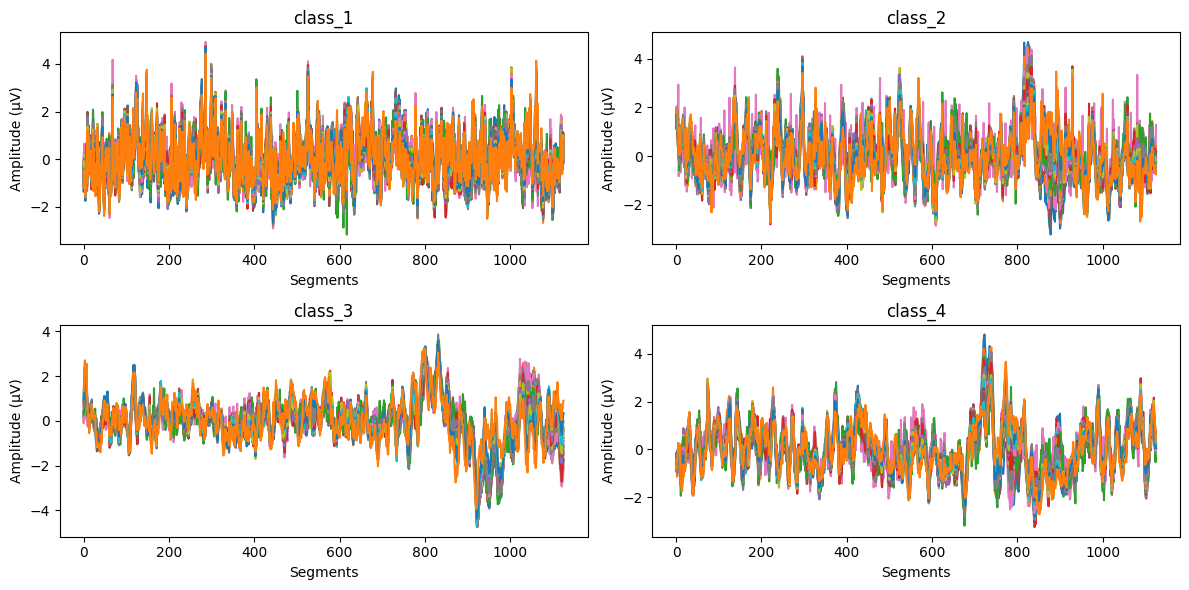

In [18]:
import numpy as np
import os
import matplotlib.pyplot as plt

# Define the path to the dataset
base_path = 'data/BCICIV_2a_gdf/processed_epoch_final2'

# Class folders
class_folders = ['class_1', 'class_2', 'class_3', 'class_4']

# Dictionary to store one epoch from each class
class_examples = {}

# Load one example epoch from each class
for class_folder in class_folders:
    folder_path = os.path.join(base_path, class_folder)
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.npy'):
            file_path = os.path.join(folder_path, file_name)
            try:
                epoch_data = np.load(file_path)
                class_examples[class_folder] = epoch_data
                break  # Load only one example from each class
            except Exception as e:
                print(f"Error loading file {file_path}: {e}")
                continue

# Plot one example from each class in a 2x2 grid
plt.figure(figsize=(12, 6))

for i, class_folder in enumerate(class_folders):
    ax = plt.subplot(2, 2, i + 1)
    epoch_data = class_examples[class_folder]
    
    # Plot each channel's data
    for ch in range(epoch_data.shape[0]):
        ax.plot(epoch_data[ch, :], label=f'Channel {ch+1}')
    
    ax.set_title(class_folder)
    ax.set_xlabel('Segments')
    ax.set_ylabel('Amplitude (µV)')

plt.tight_layout()
plt.savefig('qc_1.png', dpi=300, bbox_inches='tight')

plt.show()



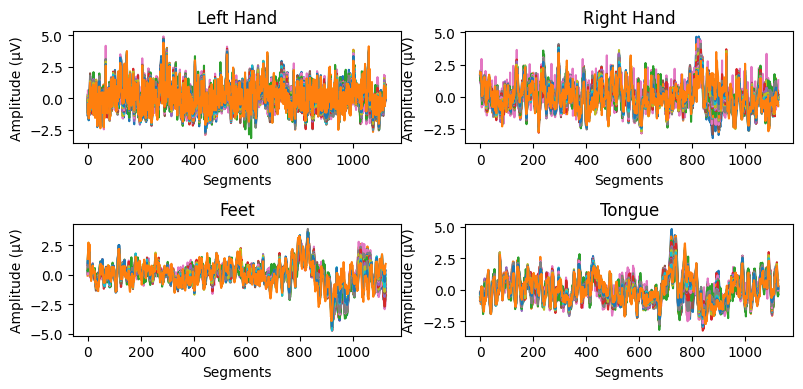

In [24]:
import numpy as np
import os
import matplotlib.pyplot as plt

# Define the path to the dataset
base_path = 'data/BCICIV_2a_gdf/processed_epoch_final2'

# Updated class names
class_names = ['Left Hand', 'Right Hand', 'Feet', 'Tongue']

# Define the corresponding folders if they differ from class names
class_folders = ['class_1', 'class_2', 'class_3', 'class_4']

# Dictionary to store one epoch from each class
class_examples = {}

# Load one example epoch from each class
for class_folder, class_name in zip(class_folders, class_names):
    folder_path = os.path.join(base_path, class_folder)
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.npy'):
            file_path = os.path.join(folder_path, file_name)
            try:
                epoch_data = np.load(file_path)
                class_examples[class_name] = epoch_data
                break  # Load only one example from each class
            except Exception as e:
                print(f"Error loading file {file_path}: {e}")
                continue

# Plot one example from each class in a 2x2 grid
plt.figure(figsize=(8, 4))

for i, class_name in enumerate(class_names):
    ax = plt.subplot(2, 2, i + 1)
    epoch_data = class_examples[class_name]
    
    # Plot each channel's data
    for ch in range(epoch_data.shape[0]):
        ax.plot(epoch_data[ch, :], label=f'Channel {ch+1}')
    
    ax.set_title(class_name)  # Use class names for titles
    ax.set_xlabel('Segments')
    ax.set_ylabel('Amplitude (µV)')  # Using the microvolt symbol

plt.tight_layout()

# Save the figure as a PNG image with 300 DPI
plt.savefig('QC_paper_1.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


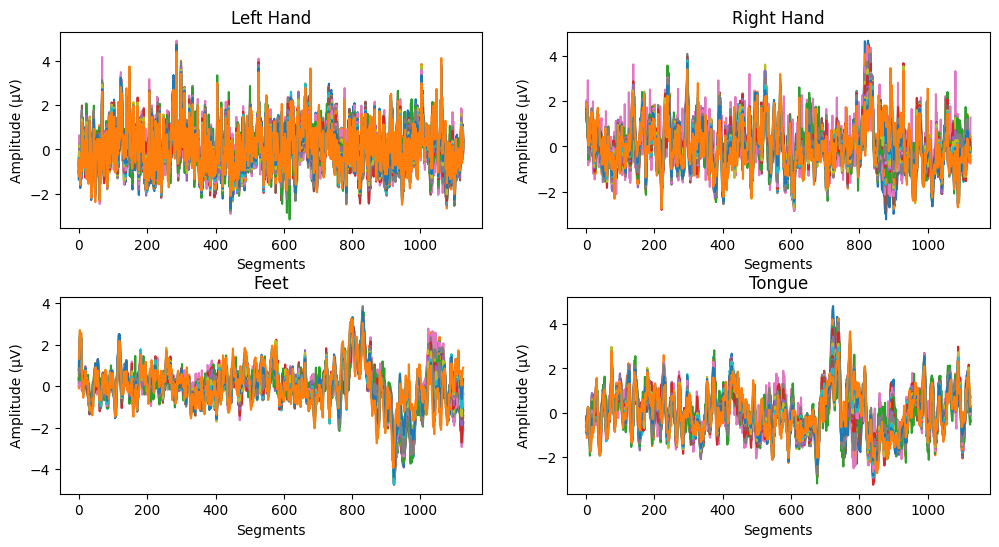

In [31]:
import numpy as np
import os
import matplotlib.pyplot as plt

# Define the path to the dataset
base_path = 'data/BCICIV_2a_gdf/processed_epoch_final2'

# Updated class names
class_names = ['Left Hand', 'Right Hand', 'Feet', 'Tongue']

# Define the corresponding folders if they differ from class names
class_folders = ['class_1', 'class_2', 'class_3', 'class_4']

# Dictionary to store one epoch from each class
class_examples = {}

# Load one example epoch from each class
for class_folder, class_name in zip(class_folders, class_names):
    folder_path = os.path.join(base_path, class_folder)
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.npy'):
            file_path = os.path.join(folder_path, file_name)
            try:
                epoch_data = np.load(file_path)
                class_examples[class_name] = epoch_data
                break  # Load only one example from each class
            except Exception as e:
                print(f"Error loading file {file_path}: {e}")
                continue

# Plot one example from each class in a 2x2 grid
plt.figure(figsize=(12, 6))

for i, class_name in enumerate(class_names):
    ax = plt.subplot(2, 2, i + 1)
    epoch_data = class_examples[class_name]
    
    # Plot each channel's data
    for ch in range(epoch_data.shape[0]):
        ax.plot(epoch_data[ch, :], label=f'Channel {ch+1}')
    
    ax.set_title(class_name)  # Use class names for titles
    ax.set_xlabel('Segments')
    ax.set_ylabel('Amplitude (µV)')  # Using the microvolt symbol

# Adjust layout to reduce gaps
plt.subplots_adjust(hspace=0.35, wspace=0.2)  # Adjust these values as needed

# Save the figure as a PNG image with 300 DPI
plt.savefig('epoch_examples.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [32]:
import os

base_path = 'data/BCICIV_2a_gdf/sub1_segment_QC'
class_folder = 'class_1'

# Full path to the expected directory
full_path = os.path.join(base_path, class_folder)

print(f"Checking folder: {full_path}")

if os.path.exists(full_path):
    print(f"Directory exists: {full_path}")
    files = os.listdir(full_path)
    print(f"Files in {full_path}: {files}")
else:
    print(f"Directory not found: {full_path}")


Checking folder: data/BCICIV_2a_gdf/sub1_segment_QC/class_1
Directory exists: data/BCICIV_2a_gdf/sub1_segment_QC/class_1
Files in data/BCICIV_2a_gdf/sub1_segment_QC/class_1: ['sub_epoch_4.npy', 'sub_epoch_136.npy', 'sub_epoch_99.npy', 'sub_epoch_146.npy', 'sub_epoch_11.npy', 'sub_epoch_121.npy', 'sub_epoch_226.npy', 'sub_epoch_280.npy', 'sub_epoch_199.npy', 'sub_epoch_276.npy', 'sub_epoch_49.npy', 'sub_epoch_206.npy', 'sub_epoch_96.npy', 'sub_epoch_128.npy', 'sub_epoch_144.npy', 'sub_epoch_183.npy', 'sub_epoch_127.npy', 'sub_epoch_198.npy', 'sub_epoch_286.npy', 'sub_epoch_169.npy', 'sub_epoch_194.npy', 'sub_epoch_284.npy', 'sub_epoch_274.npy', 'sub_epoch_62.npy', 'sub_epoch_77.npy', 'sub_epoch_179.npy', 'sub_epoch_241.npy', 'sub_epoch_218.npy', 'sub_epoch_269.npy', 'sub_epoch_153.npy', 'sub_epoch_188.npy', 'sub_epoch_80.npy', 'sub_epoch_69.npy', 'sub_epoch_266.npy', 'sub_epoch_13.npy', 'sub_epoch_271.npy', 'sub_epoch_155.npy', 'sub_epoch_85.npy', 'sub_epoch_25.npy', 'sub_epoch_177.npy'

In [1]:
import os
import numpy as np
import mne
import pywt
from scipy import signal
from sklearn import preprocessing
from spectrum import arburg

class FeatureExtractor:
    def __init__(self, **kwargs):
        # Default dataset path and configuration
        self.dataset_path = kwargs.pop('dataset_path', 'data/BCICIV_2a_gdf/sub1_segment_QC')
        self.save_path = kwargs.pop('save_path', 'output/path')
        self.n_sub = kwargs.pop('n_sub', 1)  # Adjust if you have more subjects
        self.subjects = kwargs.pop('sub_list', [1])  # Adjust if you have more subjects
        self.sample_freq = kwargs.pop('sample_freq', 250)
        self.data_aug = kwargs.pop('data_aug', True)
        self.n_hop = kwargs.pop('n_hop', 0.1)
        self.window_sz = kwargs.pop('window_sz', 2)
        self.low_freq = kwargs.pop('low_freq', 0.5)
        self.high_freq = kwargs.pop('high_freq', 35)
        self.wavelet = kwargs.pop('wavelet', True)
        self.f_bank = kwargs.pop('f_bank', False)
        self.wpd_noc = kwargs.pop('wpd_noc', False)
        self.n_bands = kwargs.pop('n_bands', 8)
        self.low_frequencies = kwargs.pop('low_frequencies', np.arange(4, 37, 1))
        self.high_frequencies = kwargs.pop('high_frequencies', np.arange(8, 41, 1))
        self.feature_list = kwargs.pop('feature_list', [0, 1, 2, 6, 8, 12, 13, 19, 21])

        if not os.path.exists(self.save_path):
            os.makedirs(self.save_path)

    def load_data(self, class_name, subject_id):
        class_folder = os.path.join(self.dataset_path, class_name)
        files = [f for f in os.listdir(class_folder) if f.endswith('.npy')]
        data = []
        for file in files:
            file_path = os.path.join(class_folder, file)
            if os.path.isfile(file_path):
                data.append(np.load(file_path))
            else:
                print(f"File not found: {file_path}")
        if data:
            return np.concatenate(data, axis=0)  # Assuming concatenation along the first axis
        else:
            print(f"No data loaded for class {class_name} and subject {subject_id}")
            return np.array([])

    def extract_features(self):
        for sub_id in self.subjects:
            sub_id_str = f'sub{sub_id}'
            subject_path = os.path.join(self.dataset_path, sub_id_str)
            if not os.path.exists(subject_path):
                print(f"Subject folder not found: {subject_path}")
                continue
            
            class_data = {}
            for class_name in ['class_1', 'class_2', 'class_3', 'class_4']:
                class_data[class_name] = self.load_data(class_name, sub_id)

            # Example processing for class_1
            if class_data['class_1'].size > 0:
                x_data = class_data['class_1']
                y_data = np.ones(x_data.shape[0])  # Dummy labels for demonstration

                # Process x_data here, e.g., filtering, feature extraction
                print(f"Data shape for class_1: {x_data.shape}")

                # Continue with processing as per your needs
                # Example: feature extraction
                features = np.zeros((x_data.shape[0], x_data.shape[1], 22))
                for i in range(x_data.shape[0]):
                    for j in range(x_data.shape[1]):
                        x = x_data[i, j, :]
                        if 0 in self.feature_list:
                            features[i, j, 0] = np.mean(np.abs(x))
                        if 1 in self.feature_list:
                            features[i, j, 1] = np.sqrt(np.mean(x ** 2))
                        if 2 in self.feature_list:
                            features[i, j, 2] = np.mean(np.diff(x))
                        if 6 in self.feature_list:
                            features[i, j, 6] = np.mean(np.abs(x) ** 2)
                        if 8 in self.feature_list:
                            features[i, j, 8] = np.std(x)
                        if 12 in self.feature_list:
                            features[i, j, 12] = np.sum(x ** 2)
                        if 13 in self.feature_list:
                            hjorth_activity, hjorth_mobility, hjorth_complexity = self.hjorth(x)
                            features[i, j, 13] = np.mean(hjorth_activity)
                            features[i, j, 14] = np.mean(hjorth_mobility)
                            features[i, j, 15] = np.mean(hjorth_complexity)
                        if 19 in self.feature_list:
                            fft_vals = np.abs(np.fft.fft(x))
                            features[i, j, 19] = np.max(fft_vals)
                        if 21 in self.feature_list:
                            ar_coeffs = arburg(x, 4)
                            features[i, j, 21] = np.mean(np.abs(ar_coeffs))

                features_save_path = os.path.join(self.save_path, f'features_{sub_id_str}_class_1.npy')
                np.save(features_save_path, features)
                print(f"Extracted features for subject {sub_id_str} in class 1")

            # Repeat for other classes as needed

    def hjorth(self, xV):
        hjorth_activity = np.var(xV, axis=1)
        hjorth_mobility = np.sqrt(np.var(np.diff(xV, axis=1), axis=1) / hjorth_activity)
        hjorth_diffmobility = np.sqrt(np.var(np.diff(np.diff(xV, axis=1), axis=1), axis=1) / np.var(np.diff(xV, axis=1), axis=1))
        hjorth_complexity = hjorth_diffmobility / hjorth_mobility
        return hjorth_activity, hjorth_mobility, hjorth_complexity


In [3]:
import os
import numpy as np

class FeatureExtractor:
    def __init__(self, dataset_path, save_path):
        self.dataset_path = dataset_path
        self.save_path = save_path

        if not os.path.exists(self.save_path):
            os.makedirs(self.save_path)

    def load_data(self, class_name):
        class_folder = os.path.join(self.dataset_path, class_name)
        if not os.path.exists(class_folder):
            print(f"Class folder not found: {class_folder}")
            return []

        files = [f for f in os.listdir(class_folder) if f.endswith('.npy')]
        data = []
        for file in files:
            file_path = os.path.join(class_folder, file)
            if os.path.isfile(file_path):
                try:
                    data.append(np.load(file_path))
                    print(f"Loaded file: {file_path}")
                except Exception as e:
                    print(f"Error loading file {file_path}: {e}")
            else:
                print(f"File not found: {file_path}")

        if data:
            concatenated_data = np.concatenate(data, axis=0)
            print(f"Concatenated data shape: {concatenated_data.shape}")
            return concatenated_data
        else:
            print(f"No data loaded for class {class_name}")
            return np.array([])

    def extract_features(self):
        for class_name in ['class_1', 'class_2', 'class_3', 'class_4']:
            class_data = self.load_data(class_name)
            # Here you would implement your feature extraction on class_data
            # For now, let's just print the shape of the loaded data
            if class_data.size > 0:
                print(f"Data for {class_name} loaded with shape: {class_data.shape}")
            else:
                print(f"No data available for {class_name}")

# Usage
extractor = FeatureExtractor(
    dataset_path='data/BCICIV_2a_gdf/sub1_segment_QC', 
    save_path='output/path'
)
extractor.extract_features()


Loaded file: data/BCICIV_2a_gdf/sub1_segment_QC/class_1/sub_epoch_4.npy
Loaded file: data/BCICIV_2a_gdf/sub1_segment_QC/class_1/sub_epoch_136.npy
Loaded file: data/BCICIV_2a_gdf/sub1_segment_QC/class_1/sub_epoch_99.npy
Loaded file: data/BCICIV_2a_gdf/sub1_segment_QC/class_1/sub_epoch_146.npy
Loaded file: data/BCICIV_2a_gdf/sub1_segment_QC/class_1/sub_epoch_11.npy
Loaded file: data/BCICIV_2a_gdf/sub1_segment_QC/class_1/sub_epoch_121.npy
Loaded file: data/BCICIV_2a_gdf/sub1_segment_QC/class_1/sub_epoch_226.npy
Loaded file: data/BCICIV_2a_gdf/sub1_segment_QC/class_1/sub_epoch_280.npy
Loaded file: data/BCICIV_2a_gdf/sub1_segment_QC/class_1/sub_epoch_199.npy
Loaded file: data/BCICIV_2a_gdf/sub1_segment_QC/class_1/sub_epoch_276.npy
Loaded file: data/BCICIV_2a_gdf/sub1_segment_QC/class_1/sub_epoch_49.npy
Loaded file: data/BCICIV_2a_gdf/sub1_segment_QC/class_1/sub_epoch_206.npy
Loaded file: data/BCICIV_2a_gdf/sub1_segment_QC/class_1/sub_epoch_96.npy
Loaded file: data/BCICIV_2a_gdf/sub1_segment

In [7]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load and concatenate the data for all classes
def load_and_concatenate_data(classes, data_path):
    all_data = []
    for class_label in classes:
        class_data = []
        class_folder = f"{data_path}/{class_label}"
        for file in os.listdir(class_folder):
            if file.endswith('.npy'):
                file_path = os.path.join(class_folder, file)
                epoch_data = np.load(file_path)
                class_data.append(epoch_data)
        concatenated_data = np.concatenate(class_data, axis=0)
        all_data.append(concatenated_data)
    return all_data

data_path = 'data/BCICIV_2a_gdf/sub1_segment_QC'
classes = ['class_1', 'class_2', 'class_3', 'class_4']
all_data = load_and_concatenate_data(classes, data_path)

# Combine data from all classes
combined_data = np.concatenate(all_data, axis=0)

# Scaling data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(combined_data)


In [ ]:
import scipy.io
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
from xgboost import XGBClassifier

# Load the .mat file
data = scipy.io.loadmat('data/BCICIV_2a_gdf/processed_features_vmd/combined_features_labels.mat')

# Extract features and labels
X = data['features']
y = data['labels']

# Convert complex values to real if necessary
X = np.real(X)

# Ensure labels are a 1D array
y = y.flatten()

# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=255)

# Apply SVM classifier
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)
y_pred_svm = svm_classifier.predict(X_val)
accuracy_svm = accuracy_score(y_val, y_pred_svm)
report_svm = classification_report(y_val, y_pred_svm)

print(f"SVM Accuracy: {accuracy_svm}")
print(f"SVM Classification Report:\n{report_svm}")

# Apply XGBoost classifier
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_classifier.fit(X_train, y_train)
y_pred_xgb = xgb_classifier.predict(X_val)
accuracy_xgb = accuracy_score(y_val, y_pred_xgb)
report_xgb = classification_report(y_val, y_pred_xgb)

print(f"XGBoost Accuracy: {accuracy_xgb}")
print(f"XGBoost Classification Report:\n{report_xgb}")


In [ ]:
import numpy as np
import os
import mne
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Define the path to the dataset and the output directory
gdf_path = 'data/BCICIV_2a_gdf/A02T.gdf'
output_dir = 'data/BCICIV_2a_gdf/processed_epoch_sub2_QC'

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Step 1: Load the BCI-IV 2a dataset
raw = mne.io.read_raw_gdf(gdf_path, preload=True)

# Remove the last three channels (EOG-left, EOG-central, and EOG-right)
raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])

# Step 2: Extract epochs for each class using provided event IDs
event_id = {'769': 7, '770': 8, '771': 9, '772': 10}
events, _ = mne.events_from_annotations(raw, event_id=event_id)
tmin, tmax = 1.5, 6  # 4.5 seconds epochs starting at 1.5s
print(f'Number of events: {len(events)}')

# Creating epochs for each class
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline=None, preload=True)
data = epochs.get_data()  # shape is (n_epochs, n_channels, n_times)

# Standardize each channel
data = (data - data.mean(axis=2, keepdims=True)) / data.std(axis=2, keepdims=True)

# Initial Temporal Feature Extraction Module (iTFE Module)
def extract_temporal_features(epoch_data):
    # Extract temporal features: mean and std for each channel
    mean_features = epoch_data.mean(axis=1)
    std_features = epoch_data.std(axis=1)
    # Concatenate features to form a feature vector
    features = np.concatenate((mean_features, std_features), axis=0)
    return features

# Step 3: Save each epoch and its features
class_counts = {7: 0, 8: 0, 9: 0, 10: 0}
features_list = []
labels_list = []

for i, epoch_data in enumerate(data):
    # Adjust labels to start from 0 by subtracting 7 from each label
    label = epochs.events[i, -1]
    file_path = os.path.join(output_dir, f'epoch_{i+1}_class_{label - 7}.npy')
    np.save(file_path, epoch_data)
    
    # Extract and save features
    features = extract_temporal_features(epoch_data)
    features_path = os.path.join(output_dir, f'features_{i+1}_class_{label - 7}.npy')
    np.save(features_path, features)
    
    features_list.append(features)
    labels_list.append(label - 7)
    
    class_counts[label] += 1

print(f'Saved {len(data)} epochs and their features to {output_dir}')

# Convert features and labels to numpy arrays
X = np.array(features_list)
y = np.array(labels_list)

# Step 4: Train and evaluate classifiers

# Example train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Example standardization (scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Example feature selection (using first 10 features)
selected_feature_indices = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]  # Adjust this list based on the actual number of features
print(f'Sample Epoch Shape: {data[0].shape}')
print(f'Number of Epochs: {len(data)}')

X_train_selected = X_train_scaled[:, selected_feature_indices]
X_test_selected = X_test_scaled[:, selected_feature_indices]

# Compare with Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_selected, y_train)
y_pred_rf = rf_classifier.predict(X_test_selected)

# Evaluate Random Forest performance
accuracy_rf = accuracy_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
confusion_matrix_rf = confusion_matrix(y_test, y_pred_rf)

print("\nRandom Forest Metrics:")
print(f"Accuracy: {accuracy_rf}")
print(f"Recall: {recall_rf}")
print(f"Confusion Matrix:\n{confusion_matrix_rf}")

# Compare with XGBoost Classifier
xgb_classifier = XGBClassifier(random_state=42)
xgb_classifier.fit(X_train_selected, y_train)
y_pred_xgb = xgb_classifier.predict(X_test_selected)

# Evaluate XGBoost performance
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb, average='weighted')
confusion_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

print("\nXGBoost Metrics:")
print(f"Accuracy: {accuracy_xgb}")
print(f"Recall: {recall_xgb}")
print(f"Confusion Matrix:\n{confusion_matrix_xgb}")

# Optionally, visualize or further analyze the results

# Example: Visualizing the first two dimensions of the selected features
plt.figure(figsize=(10, 6))
plt.scatter(X_test_selected[:, 0], X_test_selected[:, 1], c=y_pred_xgb, cmap='viridis')
plt.title('XGBoost Predictions on Test Data')
plt.colorbar()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


Extracting EDF parameters from /work/data/BCICIV_2a_gdf/A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


/opt/conda/envs/cuquantum-24.03/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['769', '770', '771', '772']
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1126 original time points ...
1 bad epochs dropped


/tmp/ipykernel_665/1245523118.py:32: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # shape is (n_epochs, n_channels, n_times)


Saved 287 epochs and their features to data/BCICIV_2a_gdf/processed_epoch_sub1_QCn
Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Best parameters for XGBoost: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}

Tuned Random Forest Metrics:
Accuracy: 0.27586206896551724
Recall: 0.27586206896551724
Confusion Matrix:
[[2 4 3 4]
 [3 5 4 4]
 [4 2 4 7]
 [1 2 4 5]]

Tuned XGBoost Metrics:
Accuracy: 0.27586206896551724
Recall: 0.27586206896551724
Confusion Matrix:
[[3 2 5 3]
 [7 4 3 2]
 [3 5 6 3]
 [1 5 3 3]]


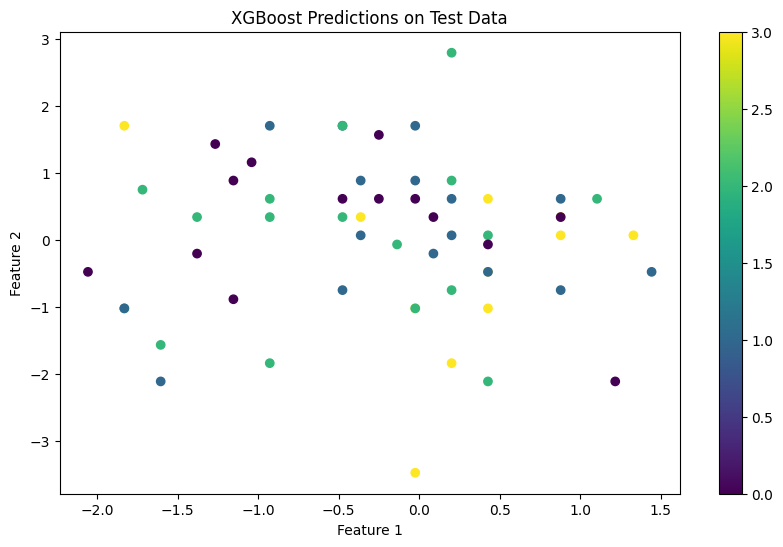

In [9]:
import numpy as np
import os
import mne
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, f_classif

# Define the path to the dataset and the output directory
gdf_path = 'data/BCICIV_2a_gdf/A01T.gdf'
output_dir = 'data/BCICIV_2a_gdf/processed_epoch_sub1_QCn'

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Step 1: Load the BCI-IV 2a dataset
raw = mne.io.read_raw_gdf(gdf_path, preload=True)

# Remove the last three channels (EOG-left, EOG-central, and EOG-right)
raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])

# Step 2: Extract epochs for each class using provided event IDs
event_id = {'769': 7, '770': 8, '771': 9, '772': 10}
events, _ = mne.events_from_annotations(raw, event_id=event_id)
tmin, tmax = 1.5, 6  # 4.5 seconds epochs starting at 1.5s

# Creating epochs for each class
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline=None, preload=True)
data = epochs.get_data()  # shape is (n_epochs, n_channels, n_times)

# Standardize each channel
data = (data - data.mean(axis=2, keepdims=True)) / data.std(axis=2, keepdims=True)

# Initial Temporal Feature Extraction Module (iTFE Module)
def extract_temporal_features(epoch_data):
    # Extract temporal features: mean and std for each channel
    mean_features = epoch_data.mean(axis=1)
    std_features = epoch_data.std(axis=1)
    # Concatenate features to form a feature vector
    features = np.concatenate((mean_features, std_features), axis=0)
    return features

# Step 3: Save each epoch and its features
class_counts = {7: 0, 8: 0, 9: 0, 10: 0}
features_list = []
labels_list = []

for i, epoch_data in enumerate(data):
    # Adjust labels to start from 0 by subtracting 7 from each label
    label = epochs.events[i, -1]
    file_path = os.path.join(output_dir, f'epoch_{i+1}_class_{label - 7}.npy')
    np.save(file_path, epoch_data)
    
    # Extract and save features
    features = extract_temporal_features(epoch_data)
    features_path = os.path.join(output_dir, f'features_{i+1}_class_{label - 7}.npy')
    np.save(features_path, features)
    
    features_list.append(features)
    labels_list.append(label - 7)
    
    class_counts[label] += 1

print(f'Saved {len(data)} epochs and their features to {output_dir}')

# Convert features and labels to numpy arrays
X = np.array(features_list)
y = np.array(labels_list)

# Step 4: Train and evaluate classifiers

# Example train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Example standardization (scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature Selection
selector = SelectKBest(f_classif, k=20)  # Adjust k based on the number of features
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

# Hyperparameter tuning for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5)
rf_grid_search.fit(X_train_selected, y_train)
print(f'Best parameters for Random Forest: {rf_grid_search.best_params_}')

# Hyperparameter tuning for XGBoost
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2]
}
xgb_grid_search = GridSearchCV(XGBClassifier(random_state=42), xgb_param_grid, cv=5)
xgb_grid_search.fit(X_train_selected, y_train)
print(f'Best parameters for XGBoost: {xgb_grid_search.best_params_}')

# Train with best parameters
rf_best = rf_grid_search.best_estimator_
xgb_best = xgb_grid_search.best_estimator_

# Evaluate best models
y_pred_rf_best = rf_best.predict(X_test_selected)
y_pred_xgb_best = xgb_best.predict(X_test_selected)

# Print metrics for tuned models
print("\nTuned Random Forest Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf_best)}")
print(f"Recall: {recall_score(y_test, y_pred_rf_best, average='weighted')}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_rf_best)}")

print("\nTuned XGBoost Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb_best)}")
print(f"Recall: {recall_score(y_test, y_pred_xgb_best, average='weighted')}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_xgb_best)}")

# Optionally, visualize or further analyze the results

# Example: Visualizing the first two dimensions of the selected features
plt.figure(figsize=(10, 6))
plt.scatter(X_test_selected[:, 0], X_test_selected[:, 1], c=y_pred_xgb_best, cmap='viridis')
plt.title('XGBoost Predictions on Test Data')
plt.colorbar()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


In [12]:
import numpy as np
import os
import mne
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, precision_recall_fscore_support, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns

# Define the path to the dataset and the output directory
gdf_dir = 'data/BCICIV_2a_gdf'
output_dir = 'data/BCICIV_2a_gdf/Epoch_vol3'

# List of subject files
subjects = ['A01T.gdf', 'A02T.gdf', 'A03T.gdf', 'A04T.gdf', 'A05T.gdf', 'A06T.gdf', 'A07T.gdf', 'A08T.gdf', 'A09T.gdf']

# Event IDs for the classes
event_id = {'769': 7, '770': 8, '771': 9, '772': 10}
tmin, tmax = 1.5, 6  # 4.5 seconds epochs starting at 1.5s

def extract_features(epoch_data):
    # Example feature extraction: mean and standard deviation
    mean_features = epoch_data.mean(axis=1)
    std_features = epoch_data.std(axis=1)
    features = np.concatenate((mean_features, std_features), axis=0)
    return features

def load_subject_data(subject_file):
    gdf_path = os.path.join(gdf_dir, subject_file)
    raw = mne.io.read_raw_gdf(gdf_path, preload=True)
    raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])
    events, _ = mne.events_from_annotations(raw, event_id=event_id)
    epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline=None, preload=True)
    data = epochs.get_data()
    data = (data - data.mean(axis=2, keepdims=True)) / data.std(axis=2, keepdims=True)
    features = []
    labels = []
    for i, epoch_data in enumerate(data):
        label = epochs.events[i, -1] - 7
        features.append(extract_features(epoch_data))
        labels.append(label)
    return np.array(features), np.array(labels)

# Collect all data
all_features = []
all_labels = []
subject_list = []

for subject in subjects:
    features, labels = load_subject_data(subject)
    all_features.append(features)
    all_labels.append(labels)
    subject_list.extend([subject] * len(labels))

X = np.vstack(all_features)
y = np.hstack(all_labels)
subjects = np.array(subject_list)

# Define cross-subject validation
n_splits = len(np.unique(subjects))
cv = GroupKFold(n_splits=n_splits)

# Store results
results = {'SVM': [], 'RandomForest': []}

for train_subjects, test_subjects in cv.split(X, y, groups=subjects):
    X_train, X_test = X[train_subjects], X[test_subjects]
    y_train, y_test = y[train_subjects], y[test_subjects]

    # Standardization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Feature Selection
    selector = SelectKBest(f_classif, k=20)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)

    # Train and evaluate SVM
    svm_param_grid = {
        'C': [0.1, 1, 10],
        'gamma': [0.001, 0.01, 0.1],
        'kernel': ['linear', 'rbf']
    }
    svm_grid_search = GridSearchCV(SVC(), svm_param_grid, cv=5, return_train_score=True)
    svm_grid_search.fit(X_train_selected, y_train)
    svm_best = svm_grid_search.best_estimator_
    y_pred_svm_best = svm_best.predict(X_test_selected)
    results['SVM'].append({
        'accuracy': accuracy_score(y_test, y_pred_svm_best),
        'recall': recall_score(y_test, y_pred_svm_best, average='weighted'),
        'precision': precision_recall_fscore_support(y_test, y_pred_svm_best, average='weighted')[0],
        'f1': precision_recall_fscore_support(y_test, y_pred_svm_best, average='weighted')[2],
        'confusion_matrix': confusion_matrix(y_test, y_pred_svm_best),
        'best_params': svm_grid_search.best_params_
    })

    # Train and evaluate RandomForest
    rf = RandomForestClassifier(class_weight='balanced')
    rf.fit(X_train_selected, y_train)
    y_pred_rf = rf.predict(X_test_selected)
    results['RandomForest'].append({
        'accuracy': accuracy_score(y_test, y_pred_rf),
        'recall': recall_score(y_test, y_pred_rf, average='weighted'),
        'precision': precision_recall_fscore_support(y_test, y_pred_rf, average='weighted')[0],
        'f1': precision_recall_fscore_support(y_test, y_pred_rf, average='weighted')[2],
        'confusion_matrix': confusion_matrix(y_test, y_pred_rf)
    })

# Print results
for model_name in ['SVM', 'RandomForest']:
    print(f"\n{model_name} Results:")
    for i, result in enumerate(results[model_name]):
        print(f"\nFold {i + 1}:")
        print(f"Accuracy: {result['accuracy']}")
        print(f"Recall: {result['recall']}")
        print(f"Precision: {result['precision']}")
        print(f"F1-score: {result['f1']}")
        print(f"Confusion Matrix:\n{result['confusion_matrix']}")
        if 'best_params' in result:
            print(f"Best parameters: {result['best_params']}")

print("Cross-subject validation complete.")


Extracting EDF parameters from /work/data/BCICIV_2a_gdf/A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


/opt/conda/envs/cuquantum-24.03/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['769', '770', '771', '772']
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1126 original time points ...
1 bad epochs dropped
Extracting EDF parameters from /work/data/BCICIV_2a_gdf/A02T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 677168  =      0.000 ...  2708.672 secs...


/tmp/ipykernel_9441/2975761811.py:37: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()
/opt/conda/envs/cuquantum-24.03/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['769', '770', '771', '772']
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1126 original time points ...
1 bad epochs dropped
Extracting EDF parameters from /work/data/BCICIV_2a_gdf/A03T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 660529  =      0.000 ...  2642.116 secs...


/tmp/ipykernel_9441/2975761811.py:37: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()
/opt/conda/envs/cuquantum-24.03/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['769', '770', '771', '772']
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1126 original time points ...
1 bad epochs dropped
Extracting EDF parameters from /work/data/BCICIV_2a_gdf/A04T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 600914  =      0.000 ...  2403.656 secs...


/tmp/ipykernel_9441/2975761811.py:37: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()
/opt/conda/envs/cuquantum-24.03/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['769', '770', '771', '772']
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1126 original time points ...
1 bad epochs dropped
Extracting EDF parameters from /work/data/BCICIV_2a_gdf/A05T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 686119  =      0.000 ...  2744.476 secs...


/tmp/ipykernel_9441/2975761811.py:37: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()
/opt/conda/envs/cuquantum-24.03/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['769', '770', '771', '772']
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1126 original time points ...
1 bad epochs dropped
Extracting EDF parameters from /work/data/BCICIV_2a_gdf/A06T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 678979  =      0.000 ...  2715.916 secs...


/tmp/ipykernel_9441/2975761811.py:37: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()
/opt/conda/envs/cuquantum-24.03/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['769', '770', '771', '772']
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1126 original time points ...
1 bad epochs dropped
Extracting EDF parameters from /work/data/BCICIV_2a_gdf/A07T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 681070  =      0.000 ...  2724.280 secs...


/tmp/ipykernel_9441/2975761811.py:37: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()
/opt/conda/envs/cuquantum-24.03/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['769', '770', '771', '772']
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1126 original time points ...
1 bad epochs dropped
Extracting EDF parameters from /work/data/BCICIV_2a_gdf/A08T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 675269  =      0.000 ...  2701.076 secs...


/tmp/ipykernel_9441/2975761811.py:37: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()
/opt/conda/envs/cuquantum-24.03/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['769', '770', '771', '772']
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1126 original time points ...
1 bad epochs dropped
Extracting EDF parameters from /work/data/BCICIV_2a_gdf/A09T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 673327  =      0.000 ...  2693.308 secs...


/tmp/ipykernel_9441/2975761811.py:37: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()
/opt/conda/envs/cuquantum-24.03/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['769', '770', '771', '772']
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1126 original time points ...
1 bad epochs dropped


/tmp/ipykernel_9441/2975761811.py:37: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()



SVM Results:

Fold 1:
Accuracy: 0.2682926829268293
Recall: 0.2682926829268293
Precision: 0.2641738492572896
F1-score: 0.26525488002499237
Confusion Matrix:
[[24 13 17 18]
 [20 17 23 12]
 [17 15 24 15]
 [14 30 16 12]]
Best parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

Fold 2:
Accuracy: 0.22996515679442509
Recall: 0.22996515679442509
Precision: 0.2324898270954344
F1-score: 0.2295247676551808
Confusion Matrix:
[[19 20 21 12]
 [21 20 21 10]
 [21 20 13 17]
 [15 22 21 14]]
Best parameters: {'C': 10, 'gamma': 0.001, 'kernel': 'linear'}

Fold 3:
Accuracy: 0.30662020905923343
Recall: 0.30662020905923343
Precision: 0.30692308393896506
F1-score: 0.3039391450012815
Confusion Matrix:
[[28 17 14 13]
 [24 24  7 17]
 [19 22 19 11]
 [18 19 18 17]]
Best parameters: {'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}

Fold 4:
Accuracy: 0.2578397212543554
Recall: 0.2578397212543554
Precision: 0.2650552119193234
F1-score: 0.25872144049889967
Confusion Matrix:
[[19 27 13 13]
 [23 21 16 12]
 [24 17 17 13]

In [ ]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from qiskit import QuantumCircuit, transpile, assemble
from qiskit.circuit.library import ZZFeatureMap
from qiskit_aer import AerSimulator
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel

# Load data
data = scipy.io.loadmat('data/BCICIV_2a_gdf/processed_features_vmd/combined_features_labels.mat')
X = data['features']
y = np.ravel(data['labels'])  # Flatten y to ensure it's a 1D array
X = np.real(X)

# Define AQGA function
def aqga(X, y, n_generations, n_individuals, n_features, model):
    best_fitness = -np.inf
    best_features = None
    population = np.random.randint(2, size=(n_individuals, n_features))
    
    for generation in range(n_generations):
        fitness_scores = []
        for individual in population:
            selected_features = np.where(individual == 1)[0]
            if len(selected_features) == 0:
                continue
            X_selected = X[:, selected_features]
            model.fit(X_selected, y)
            y_pred = model.predict(X_selected)
            f1 = accuracy_score(y, y_pred)
            fitness_scores.append(f1)
        fitness_scores = np.array(fitness_scores)
        if fitness_scores.max() > best_fitness:
            best_fitness = fitness_scores.max()
            best_features = population[np.argmax(fitness_scores)]
        sorted_indices = np.argsort(fitness_scores)[::-1]
        top_individuals = population[sorted_indices[:n_individuals // 2]]
        population[:n_individuals // 2] = top_individuals
        population[n_individuals // 2:] = np.random.randint(2, size=(n_individuals // 2, n_features))
    return best_features, best_fitness

# Define parameters
n_generations = 10
n_individuals = 20
n_features = X.shape[1]

# Define Quantum Feature Map and Quantum Circuit
feature_map = ZZFeatureMap(feature_dimension=min(n_features, 4), entanglement='linear')
quantum_circuit = QuantumCircuit(feature_map.num_qubits)
quantum_circuit.append(feature_map, range(feature_map.num_qubits))

# Define parameters for the circuit
params = np.random.random(feature_map.num_parameters)  # Example parameter values
param_dict = dict(zip(feature_map.parameters, params))

# Bind parameters to the quantum circuit
bound_circuit = quantum_circuit.assign_parameters(param_dict)

# Compile and run the quantum circuit
backend = AerSimulator()
compiled_circuit = transpile(bound_circuit, backend=backend)
result = backend.run(compiled_circuit).result()

# Use classical SVC model as fallback
svc_model = SVC(kernel='linear', class_weight='balanced')

# Apply AQGA for feature selection using classical SVC
best_features_svc, best_fitness_svc = aqga(X, y, n_generations, n_individuals, n_features, svc_model)

# Print results
print(f"Best Features Selected (SVC): {np.where(best_features_svc == 1)[0]}")
print(f"Best Fitness Score (SVC): {best_fitness_svc}")


/opt/conda/envs/cuquantum-24.03/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/opt/conda/envs/cuquantum-24.03/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/conda/envs/cuquantum-24.03/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited at iteration 43 with accuracies 
[6.28196131e-13 2.75793695e-06 1.50049899e-05 7.79094970e-06
 7.79548251e-06]
not reaching the requested tolerance 8.240342140197754e-06.
Use iteration 19 instead with accuracy 
5.706968120396103e-06.

  _, diffusion_map = lobpcg(
/opt/conda/envs/cuquantum-24.03/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:455: UserWa

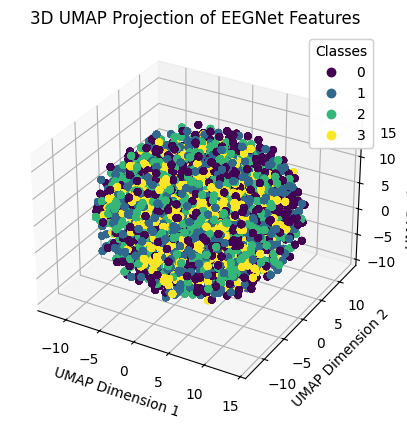

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import scipy.io

# Load data
def load_data_from_class_folder(class_folder):
    data_files = [f for f in os.listdir(class_folder) if f.endswith('.npy')]
    features = [np.load(os.path.join(class_folder, file)) for file in data_files]
    return np.concatenate(features, axis=0)

def load_and_combine_data(base_path):
    classes = ['class_0', 'class_1', 'class_2', 'class_3']
    data = []
    labels = []
    
    for i, cls in enumerate(classes):
        class_folder = os.path.join(base_path, cls)
        class_data = load_data_from_class_folder(class_folder)
        data.append(class_data)
        labels.append(np.full(class_data.shape[0], i))
    
    combined_data = np.vstack(data)
    combined_labels = np.hstack(labels)
    
    return combined_data, combined_labels

# Define base path
base_path = 'data/BCICIV_2a_gdf/epoch_finalvol1'
X, y = load_and_combine_data(base_path)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA for initial dimensionality reduction
pca = PCA(n_components=50)  # Reduce to 50 components
X_pca = pca.fit_transform(X_scaled)

# Apply UMAP for 3D projection
umap_model = umap.UMAP(n_components=3, random_state=42)
X_umap = umap_model.fit_transform(X_pca)

# Plot the 3D UMAP projection
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with different colors for each class
scatter = ax.scatter(X_umap[:, 0], X_umap[:, 1], X_umap[:, 2], c=y, cmap='viridis', marker='o')
ax.set_title('3D UMAP Projection of EEGNet Features')
ax.set_xlabel('UMAP Dimension 1')
ax.set_ylabel('UMAP Dimension 2')
ax.set_zlabel('UMAP Dimension 3')

# Add colorbar
legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend1)

plt.show()


/opt/conda/envs/cuquantum-24.03/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


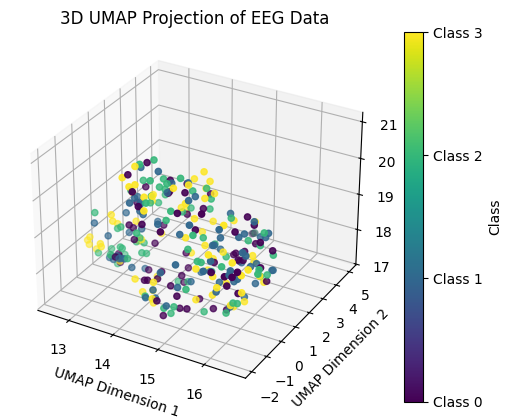

In [7]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

# Load the data
data = scipy.io.loadmat('data/BCICIV_2a_gdf/processed_features_vmd/combined_features_labels.mat')
X = data['features']
y = np.ravel(data['labels'])  # Flatten y to ensure it's a 1D array

# Ensure features are real
X = np.real(X)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply UMAP for 3D projection
umap_model = umap.UMAP(n_components=3, random_state=42)
X_umap = umap_model.fit_transform(X_scaled)

# Plot the 3D UMAP projection
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with different colors for each class
scatter = ax.scatter(X_umap[:, 0], X_umap[:, 1], X_umap[:, 2], c=y, cmap='viridis', marker='o')

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Class')
cbar.set_ticks([0, 1, 2, 3])
cbar.set_ticklabels(['Class 0', 'Class 1', 'Class 2', 'Class 3'])

# Set titles and labels
ax.set_title('3D UMAP Projection of EEG Data')
ax.set_xlabel('UMAP Dimension 1')
ax.set_ylabel('UMAP Dimension 2')
ax.set_zlabel('UMAP Dimension 3')

plt.show()


In [11]:
import numpy as np
import scipy.io
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix

# Load your data
data = scipy.io.loadmat('data/BCICIV_2a_gdf/processed_features_vmd/combined_features_labels.mat')

# Extract features and labels
X = data['features']
y = data['labels'].ravel()  # Flatten the labels array if necessary

# Convert complex values to real if necessary
X = np.real(X)

# Feature Selection using SelectKBest
def select_features(X, y, k=10):
    """ Select the top k features based on univariate statistical tests. """
    selector = SelectKBest(score_func=f_classif, k=k)
    X_new = selector.fit_transform(X, y)
    selected_features = selector.get_support(indices=True)
    return X_new, selected_features

# Apply feature selection
k = 10  # Number of top features to select
X_selected, selected_features = select_features(X, y, k)
print(f"Selected feature indices: {selected_features}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train and evaluate a classifier
classifier = RandomForestClassifier()
classifier.fit(X_train_scaled, y_train)
y_pred = classifier.predict(X_test_scaled)

# Print evaluation metrics
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred, average='weighted')}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")


Selected feature indices: [ 15  23  41  42  45  79 121 122 129 135]
Accuracy: 0.3620689655172414
Recall: 0.3620689655172414
Confusion Matrix:
[[4 4 2 3]
 [0 6 5 3]
 [3 2 7 9]
 [0 2 4 4]]


In [ ]:
import numpy as np
import scipy.io
from itertools import combinations
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Load your data
data = scipy.io.loadmat('data/BCICIV_2a_gdf/processed_features_vmd/combined_features_labels.mat')

# Extract features and labels
X = data['features']
y = data['labels'].ravel()  # Flatten the labels array if necessary

# Convert complex values to real if necessary
X = np.real(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Evaluate combinations of features
def evaluate_combinations(X_train, X_test, y_train, y_test, max_features=10):
    """ Evaluate feature combinations and return accuracies. """
    feature_count = X_train.shape[1]
    accuracies = {}
    
    for k in range(1, max_features + 1):
        for feature_indices in combinations(range(feature_count), k):
            X_train_subset = X_train[:, feature_indices]
            X_test_subset = X_test[:, feature_indices]
            
            clf = RandomForestClassifier()
            clf.fit(X_train_subset, y_train)
            y_pred = clf.predict(X_test_subset)
            
            accuracy = accuracy_score(y_test, y_pred)
            accuracies[feature_indices] = accuracy
    
    return accuracies

# Set maximum number of features to test
max_features = min(X.shape[1], 10)  # Adjust according to your data
accuracies = evaluate_combinations(X_train_scaled, X_test_scaled, y_train, y_test, max_features)

# Plotting
def plot_accuracies(accuracies):
    """ Plot the accuracies of different feature combinations. """
    plt.figure(figsize=(10, 6))
    
    for features, accuracy in accuracies.items():
        plt.plot(len(features), accuracy, 'bo', label=f"Features: {features}")

    plt.xlabel('Number of Features')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Number of Features')
    plt.legend()
    plt.grid(True)
    plt.savefig('feature_combinations_accuracy.png')
    plt.show()

plot_accuracies(accuracies)


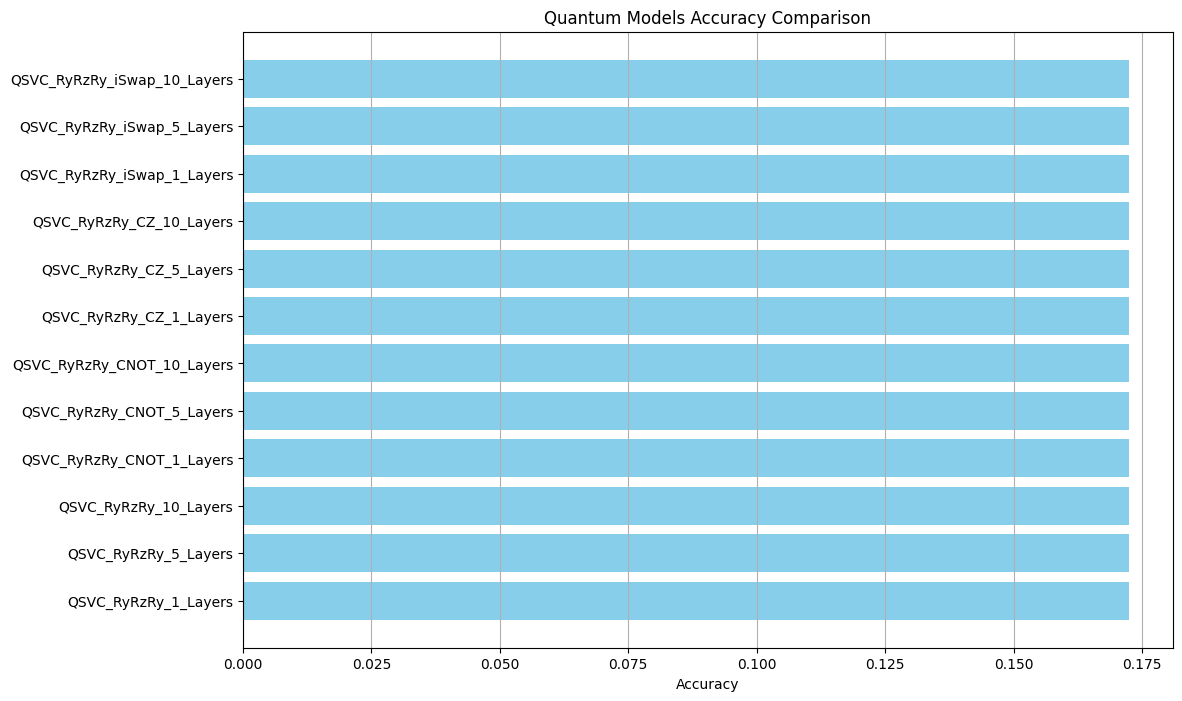

In [3]:
import numpy as np
import scipy.io
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit.circuit.library import ZZFeatureMap, iSwapGate
import matplotlib.pyplot as plt

# Define a function to create a quantum circuit with the specified gates and layers
def create_quantum_circuit(method, layers, num_qubits):
    qc = QuantumCircuit(num_qubits)
    if method == 'RyRzRy':
        for _ in range(layers):
            for qubit in range(num_qubits):
                qc.rx(np.pi / 2, qubit)
                qc.rz(np.pi / 2, qubit)
                qc.rx(np.pi / 2, qubit)
    elif method == 'RyRzRy_CNOT':
        for _ in range(layers):
            for qubit in range(num_qubits - 1):
                qc.rx(np.pi / 2, qubit)
                qc.rz(np.pi / 2, qubit)
                qc.rx(np.pi / 2, qubit)
                qc.cx(qubit, qubit + 1)
    elif method == 'RyRzRy_CZ':
        for _ in range(layers):
            for qubit in range(num_qubits - 1):
                qc.rx(np.pi / 2, qubit)
                qc.rz(np.pi / 2, qubit)
                qc.rx(np.pi / 2, qubit)
                qc.cz(qubit, qubit + 1)
    elif method == 'RyRzRy_iSwap':
        for _ in range(layers):
            for qubit in range(num_qubits - 1):
                qc.rx(np.pi / 2, qubit)
                qc.rz(np.pi / 2, qubit)
                qc.rx(np.pi / 2, qubit)
                qc.append(iSwapGate(), [qubit, qubit + 1])  # Use the correct method for iSwap
    return qc

# Define a function to process each dataset and model
def process_dataset(dataset_path):
    # Load the .mat file
    data = scipy.io.loadmat(dataset_path)
    
    # Extract features and labels
    X = data['features']
    y = data['labels']
    
    # Convert complex values to real if necessary
    X = np.real(X)
    
    # Normalize the feature matrix
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Ensure labels are a 1D array
    y = y.flatten()
    
    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=10)  # Adjust the number of components as needed
    X_train_reduced = pca.fit_transform(X_train)
    X_test_reduced = pca.transform(X_test)  # Transform test data with the same PCA
    
    # Initialize AerSimulator
    quantum_simulator = AerSimulator()
    
    # Define quantum models
    quantum_models = [
        ('RyRzRy', 1),
        ('RyRzRy', 5),
        ('RyRzRy', 10),
        ('RyRzRy_CNOT', 1),
        ('RyRzRy_CNOT', 5),
        ('RyRzRy_CNOT', 10),
        ('RyRzRy_CZ', 1),
        ('RyRzRy_CZ', 5),
        ('RyRzRy_CZ', 10),
        ('RyRzRy_iSwap', 1),
        ('RyRzRy_iSwap', 5),
        ('RyRzRy_iSwap', 10)
    ]
    
    results = {}
    for method, layers in quantum_models:
        qc = create_quantum_circuit(method, layers, X_train_reduced.shape[1])
        # Define a Quantum Kernel and QSVC
        quantum_kernel = FidelityQuantumKernel(feature_map=ZZFeatureMap(2**X_train_reduced.shape[1]))
        qsvc = QSVC(quantum_kernel=quantum_kernel)
        qsvc.fit(X_train_reduced, y_train)
        y_pred = qsvc.predict(X_test_reduced)
        accuracy = accuracy_score(y_test, y_pred)
        results[f'QSVC_{method}_{layers}_Layers'] = accuracy

    return results

# Run the processing function for your dataset
dataset_path = 'data/BCICIV_2a_gdf/processed_features_vmd/combined_features_labels.mat'
results = process_dataset(dataset_path)

# Plot the results
methods_layers = list(results.keys())
accuracies = list(results.values())

plt.figure(figsize=(12, 8))
plt.barh(methods_layers, accuracies, color='skyblue')
plt.xlabel('Accuracy')
plt.title('Quantum Models Accuracy Comparison')
plt.grid(axis='x')
plt.show()


In [5]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import networkx as nx
from scipy.stats import kruskal

# Define paths
main_directory = "Alzheimer"
save_directory = "Alzheimer\\SegmentedData"
classes = ['AD', 'FTD', 'CN']

# Load data
def load_data(main_directory, classes):
    data = []
    labels = []
    for cls in classes:
        cls_dir = os.path.join(main_directory, cls)
        for file in os.listdir(cls_dir):
            file_path = os.path.join(cls_dir, file)
            sample = np.load(file_path)
            data.append(sample)
            labels.append(cls)
    return np.array(data), np.array(labels)

data, labels = load_data(main_directory, classes)

# Split data
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Feature extraction
def extract_graph_features(eeg_data):
    features = []
    for sample in eeg_data:
        graph = nx.Graph()
        corr_matrix = np.corrcoef(sample)
        graph.add_weighted_edges_from([(i, j, corr_matrix[i, j]) for i in range(corr_matrix.shape[0]) for j in range(corr_matrix.shape[1])])
        features.append([nx.degree_centrality(graph), nx.betweenness_centrality(graph)])
    return np.array(features)

graph_features_train = extract_graph_features(X_train)
graph_features_test = extract_graph_features(X_test)

# Apply PCA
pca = PCA(n_components=0.95)
pca_features_train = pca.fit_transform(graph_features_train)
pca_features_test = pca.transform(graph_features_test)

# Kruskal-Wallis Test
_, p_value = kruskal(graph_features_train[y_train == 'AD'],
                     graph_features_train[y_train == 'FTD'],
                     graph_features_train[y_train == 'CN'])

print("P-value from Kruskal-Wallis test:", p_value)

# Classification
et_classifier = ExtraTreesClassifier(n_estimators=100, random_state=42)
dt_classifier = DecisionTreeClassifier(random_state=42)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

et_classifier.fit(pca_features_train, y_train)
dt_classifier.fit(pca_features_train, y_train)
rf_classifier.fit(pca_features_train, y_train)

et_predictions = et_classifier.predict(pca_features_test)
dt_predictions = dt_classifier.predict(pca_features_test)
rf_predictions = rf_classifier.predict(pca_features_test)

et_accuracy = accuracy_score(y_test, et_predictions)
dt_accuracy = accuracy_score(y_test, dt_predictions)
rf_accuracy = accuracy_score(y_test, rf_predictions)

print(f"Extra Trees Accuracy: {et_accuracy * 100:.2f}%")
print(f"Decision Trees Accuracy: {dt_accuracy * 100:.2f}%")
print(f"Random Forest Accuracy: {rf_accuracy * 100:.2f}%")


FileNotFoundError: [Errno 2] No such file or directory: 'Alzheimer/AD'

In [ ]:
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import hog
from skimage.color import rgb2gray
from qiskit.circuit.library import ZZFeatureMap
from qiskit_aer import AerSimulator
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel

# Quantum Genetic Algorithm (QGA) implementation
class QuantumGeneticAlgorithm:
    def __init__(self, population_size=20, generations=10, mutation_rate=0.1):
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate

    def initialize_population(self, num_features):
        return np.random.randint(0, 2, size=(self.population_size, num_features))

    def evaluate_fitness(self, X, y, population):
        fitness_scores = np.zeros(self.population_size)
        for i in range(self.population_size):
            selected_features = population[i] == 1
            if np.sum(selected_features) == 0:
                fitness_scores[i] = 0
            else:
                X_selected = X[:, selected_features]
                X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
                svm_model = SVC(kernel='linear', class_weight='balanced')
                svm_model.fit(X_train, y_train)
                predictions = svm_model.predict(X_test)
                fitness_scores[i] = accuracy_score(y_test, predictions)
        return fitness_scores

    def select_parents(self, population, fitness_scores):
        selected_indices = np.argsort(fitness_scores)[-self.population_size // 2:]
        return population[selected_indices]

    def crossover(self, parents):
        offspring = []
        for _ in range(self.population_size - parents.shape[0]):
            parent1, parent2 = parents[np.random.choice(parents.shape[0], 2, replace=False)]
            crossover_point = np.random.randint(0, len(parent1))
            child = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
            offspring.append(child)
        return np.vstack((parents, np.array(offspring)))

    def mutate(self, population):
        for i in range(self.population_size):
            if np.random.rand() < self.mutation_rate:
                mutation_point = np.random.randint(0, population.shape[1])
                population[i, mutation_point] = 1 - population[i, mutation_point]
        return population

    def fit(self, X, y):
        num_features = X.shape[1]
        population = self.initialize_population(num_features)
        for generation in range(self.generations):
            fitness_scores = self.evaluate_fitness(X, y, population)
            parents = self.select_parents(population, fitness_scores)
            population = self.crossover(parents)
            population = self.mutate(population)
        best_index = np.argmax(fitness_scores)
        return population[best_index]

# Directory containing the data
base_dir = 'data/CWT_6sec/'
classes = ['class1', 'class2', 'class3', 'class4']

# Define desired image size
image_size = (64, 64)  # Adjust size as needed

# Initialize lists to hold image data and labels
images = []
labels = []

# Loop through each class directory
for class_index, class_name in enumerate(classes):
    class_dir = os.path.join(base_dir, class_name)
    files = os.listdir(class_dir)
    image_files = [f for f in files if f.endswith('.png')]
    
    for image_file in image_files:
        image_path = os.path.join(class_dir, image_file)
        img = Image.open(image_path).convert('RGB')
        img = img.resize(image_size)
        img_array = np.array(img)
        
        # Convert image to grayscale
        img_gray = rgb2gray(img_array)
        
        # Extract HOG features
        features, _ = hog(img_gray, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=True, feature_vector=True)
        
        images.append(features)
        labels.append(class_index)

# Convert lists to numpy arrays
X = np.array(images)
y = np.array(labels)

# Normalize feature matrix
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=0.95)  # Preserve 95% of variance
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)  # Transform test data with the same PCA

# Apply QGA for feature selection
qga = QuantumGeneticAlgorithm(population_size=20, generations=10, mutation_rate=0.1)
selected_features_indices_qga = qga.fit(X_train_reduced, y_train)

# Select features
X_train_reduced_selected = X_train_reduced[:, selected_features_indices_qga == 1]
X_test_reduced_selected = X_test_reduced[:, selected_features_indices_qga == 1]

# Define quantum feature map
feature_map = ZZFeatureMap(feature_dimension=X_train_reduced_selected.shape[1], entanglement='linear')

# Initialize the quantum backend
simulator = AerSimulator()

# Define the quantum kernel (no quantum_instance argument)
quantum_kernel = FidelityQuantumKernel(feature_map=feature_map)

# Initialize QSVC
qsvc = QSVC(quantum_kernel=quantum_kernel)

# Train the QSVC
qsvc.fit(X_train_reduced_selected, y_train)

# Predict on test data
qsvc_predicted_labels = qsvc.predict(X_test_reduced_selected)

# Evaluate QSVC model
qsvc_accuracy = accuracy_score(y_test, qsvc_predicted_labels)
qsvc_report = classification_report(y_test, qsvc_predicted_labels)

print(f'QSVC Accuracy: {qsvc_accuracy * 100:.2f}%')
print(f'QSVC Classification Report:\n{qsvc_report}')
